# Gradient descent

## 1 Linear model gradients
This week we discussed gradient descent in its various forms. We talked about some of the pitfalls that can be encountered and how we can overcome them. In this notebook, we go through a variety of mechanisms that improve on the vanilla implementation of gradient descent. To start with, let's create a small, random dataset that will help us to visualise how different methods for optimizing work over a simple loss landscape.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9,9)

np.random.seed(0)

We will use a dataset generated from a line with noised added:
$$ y = x + 1 + \epsilon $$
$$ x \in [0,1]. $$

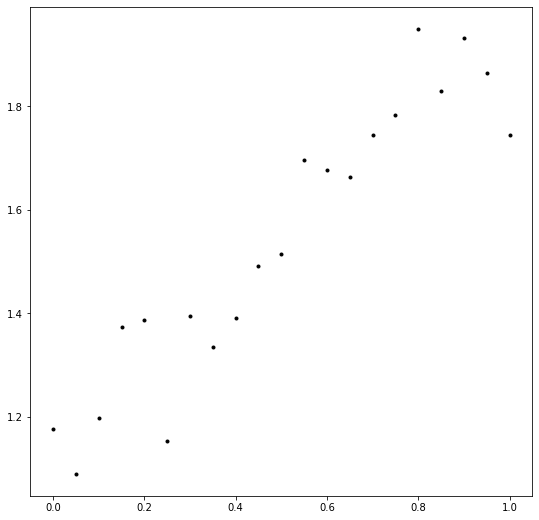

In [49]:
# Create constantly-spaced x-values
x = np.linspace(0,1,21)

# Create a linear function of $x$ with slope 1, intercept 1, and normally distributed error with sd=1
y = x + np.random.randn(len(x))*0.1 + 1.0
plt.plot(x,y,'k.')
plt.show()

Our cost function (which we could also refer to as the negative log-likelihood) is simple least squares

In [50]:
# Define cost function (sum square error between prediction and data points)
def L(w,x,y):
    return 1./2.*sum((y - w[0] - w[1]*x)**2)

# Evaluate the cost function at many values of slope and intercept, aka the brute force method.  
# To be used for visualization purposes
L_grid = np.zeros((101,101))
w0s = np.linspace(0,1.5,101)
w1s = np.linspace(0,1,101)
for i,w1 in enumerate(w1s):
    for j,w0 in enumerate(w0s):
        L_grid[i,j] = L([w0,w1],x,y)

Recall that to solve the least squares problem, we take the derivative of this thing with respect to the weights, set them equal to zero.  This produces the normal equations:
$$
\Phi^T \Phi W = \Phi^T y
$$
which have an analytical solution.  However, for the purposes of illustration, we can assume that we can't just solve them, and have to use gradient descent.  The gradient for the intercept and the slope of the line we want to fit are 
$$
\frac{\partial L}{\partial w_0} = -\sum_{i=1}^m (y_i - w_0 - w_1 x_i)
$$
$$
\frac{\partial L}{\partial w_1} = -\sum_{i=1}^m (y_i - w_0 - w_1 x_i) x_i
$$
Writing a python function for this gives us:

In [51]:
# Gradient function
def G(w,x,y):
    return np.array([-sum(y - w[0] - w[1]*x),-sum((y - w[0] - w[1]*x)*x)])

## 2 Batch Gradient Descent
### Exercise: Implement vanilla gradient descent

First, we can run so-called batch gradient descent, in which we compute the objective function considering **all the data points at once**. This is referred to as a complete batch.  We'll save our weights at each epoch, so that we can plot them.  A learning rate $\eta=0.01$ works well for this problem. Your first task is to implement vanilla gradient descent: 

In [52]:
# Create an initial guess for the weights
w = np.array([0.,0.])

# Initialize a list to hold our weight values at each step of gradient descent
w_batch = [w.copy()]

# Set the learning rate
eta = 0.01

# Loop over the data 10000 times
for i in range(10000):

    gradient = G(w,x,y) 
    # Update the weights (w) by taking a small step in the negative direction of the gradient
    
    # TODO: Implement this update using the learning rate (eta) and the gradient
    w -= eta * gradient
    
    # Append the new parameters to our list of weights
    w_batch.append(w.copy())
    
# Convert the list to a numpy array
w_batch = np.array(w_batch)

Let's visualise the path that gradient descent takes to the minimum with a plot:

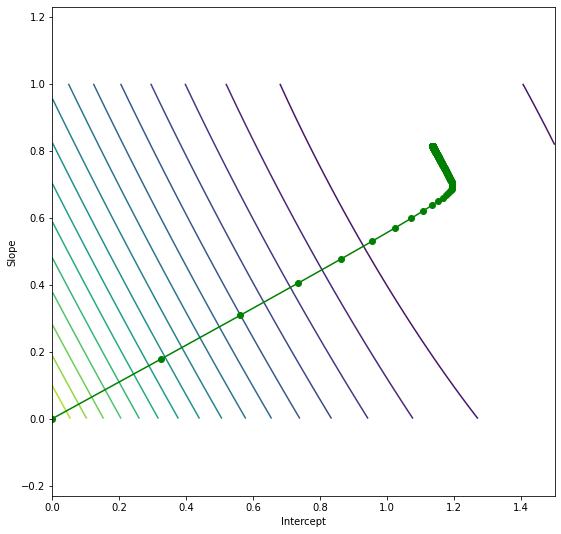

In [53]:
# Make a contour plot of the grid of cost-function values
plt.contour(w0s,w1s,L_grid,20)

# Plot the weight values on our way toward the cost-function minimum
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.axis('equal')
plt.show()

## 3 Stochastic gradient descent
It's not always possible to fit all the data in memory, and so we have to do something different.  One simple thing that we can do is to compute the gradient of the objective function considering only *one datapoint at a time*, sampled at random without replacement from the dataset, hence the name stochastic gradient descent. 

We'll save both the weight values at these individual steps, and also the weights at the end of each *epoch*, which is what we call the outer iteration in which we look at each data point once; in batch gradient descent, we look at all the data at once as a single batch, so an epoch corresponds to one iteration of BGD.  In stochastic gradient descent, we'll take $m$ steps of gradient descent per epoch.  

In [54]:
# Initialize weights
w = np.array([0.,0.])

# Initialize arrays to hold weights
w_stoch = [w.copy()]
w_epoch = [w.copy()]

# Define learning rates
eta = 0.01

# Train for 10000 epochs
for i in range(10000):
    
    # Draw random indices of the dataset
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    
    # Loop over all of the data points without replacement
    for j in random_indices:
        
        # Take as a sample the j-th element in the training data
        x_sample = x[j]
        y_sample = y[j]
        
        # Take a gradient descent step based on that single data point
        w -= eta*G(w,np.array([x_sample]),np.array([y_sample]))
        w_stoch.append(w.copy())
    
    # Store the weights at the end of the epoch
    w_epoch.append(w.copy())

# Convert lists to arrays
w_stoch = np.array(w_stoch)
w_epoch = np.array(w_epoch)


Let's plot this on top of the results from batch gradient descent

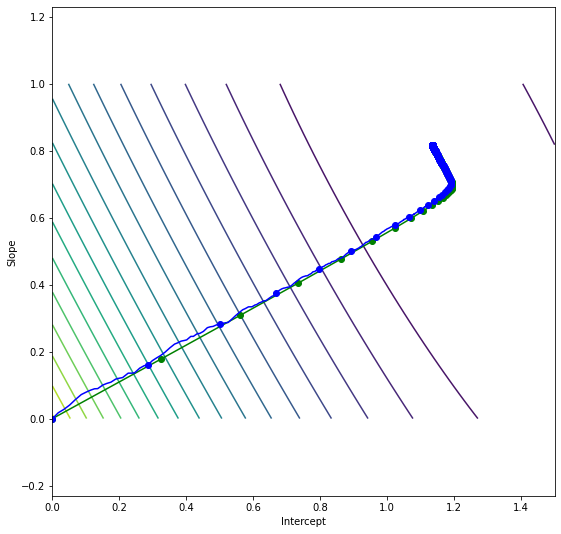

In [55]:
# Plot the error surface
plt.contour(w0s,w1s,L_grid,20)

# Plot the results of batch gradient descent in green
plt.plot(w_batch[:,0],w_batch[:,1],'go-')

# Plot the results of stochastic gradient descent in blue
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_epoch[:,0],w_epoch[:,1],'bo')

plt.axis('equal')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

There are some wiggles, but the stochastic value after each epoch falls remarkably close to the batch descent line.  This is even more interesting if we zoom in on the upper right region (near convergence).

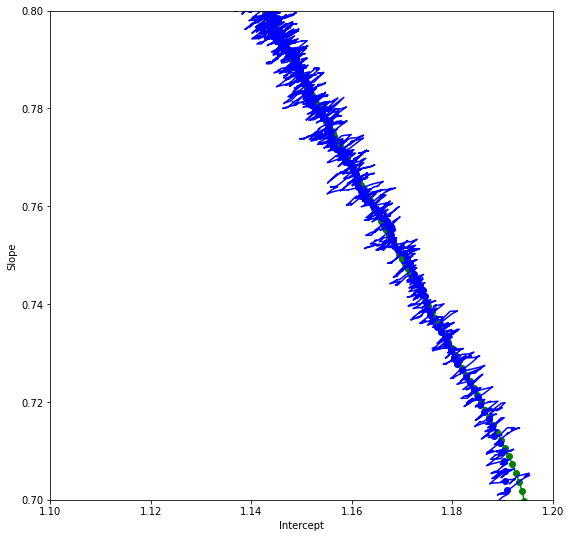

In [56]:
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_epoch[:,0],w_epoch[:,1],'bo')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.8)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

Why does this work?  Let's look at the sum of the individual weight updates in SGD over an epoch.  An update based on a single data point would be:
$$
\Delta w_{i} = \eta [y_i - w_{0,i} - w_{1,i} x_i, (y_i - w_{0,i} - w_{1,i}) x_i].
$$
What does the update after an entire epoch (i.e. a complete loop through the data) look like.  That would just be the sum over all $m$ updates in the "inner" loop, with the constant step size moved outside the sum (summation is linear after all):
$$
\Delta w_{SGD} = \eta [\sum_{i=1}^m (y_i - w_{0,i} - w_{1,i} x_i),\sum_{i=1}^m (y_i - w_{0,i} - w_{1,i} x_i)x_i]
$$
Compare this to the update for batch gradient descent
$$
\Delta w_{BGD} = \eta [\sum_{i=1}^m (y_i - w_{0} - w_{1} x_i),\sum_{i=1}^m (y_i - w_{0} - w_{1} x_i)x_i]
$$
You'll note that it's exactly the same, with the exception of the subscripts on the weights.  However, since the weights aren't changing very rapidly (we're taking small steps after all), the resulting updates are very close to identical: all the little steps taken in SGD average out to produce something quite close to batch gradient descent.


## 4 Mini-batch gradient descent for linear regression

These are two end-member options for dealing with gradient descent.  The best solution for the purposes of machine learning lies somewhere in the middle, via a technique called mini-batch gradient descent.  In mini-batch gradient descent, at each epoch we split the data-set into $k$ subsets of a specified size known as the *batch size*, and take $k$ steps based on the objective function gradient considering only the $m/k$ data points in a given mini-batch.

Notice that this method A) creates random disjoint subsets of the training data of the size $m/k$, and B) updates the weights $k$ times per epoch.  The results of mini-batch gradient descent are plotted below along with the batch and stochastic gradient descents from above, using the same initial guess for $\mathbf{w}$.

In [57]:
# Code here
# Initialize weights
w = np.array([0.,0.])

# Initialize arrays to hold weights
w_stoch = [w.copy()]
w_epoch = [w.copy()]

# Define learning rates
eta = 0.01

# Train for 10000 epochs
for i in range(10000):
    
    # Draw random indices of the dataset
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    slices = []
    for i in range(7):
        slices.append(random_indices[i:21:7])
    
    x_sample = np.zeros(3)
    y_sample = np.zeros(3)

    # Loop over all of the data points without replacement
    for _slice in slices:
        count = 0
        for j in _slice:
            # Take as a sample the j-th element in the training data
            x_sample[count] = x[j]
            y_sample[count] = y[j]
            count += 1
        
        # Take a gradient descent step based on that single data point
        w -= eta*G(w,x_sample,y_sample)
        w_stoch.append(w.copy())
    
    # Store the weights at the end of the epoch
    w_epoch.append(w.copy())

# Convert lists to arrays
w_stoch = np.array(w_stoch)
w_epoch = np.array(w_epoch)


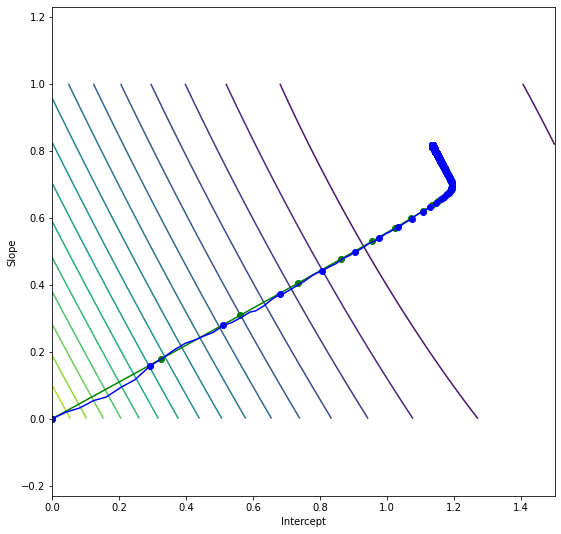

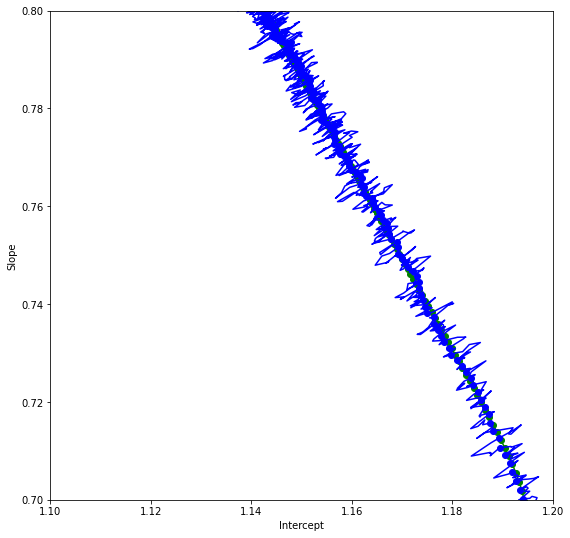

In [58]:
# Plots here
# Plot the error surface
plt.contour(w0s,w1s,L_grid,20)

# Plot the results of batch gradient descent in green
plt.plot(w_batch[:,0],w_batch[:,1],'go-')

# Plot the results of stochastic gradient descent in blue
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_epoch[:,0],w_epoch[:,1],'bo')

plt.axis('equal')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_epoch[:,0],w_epoch[:,1],'bo')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.8)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

You should expect the mini-batch gradient descent produces results which are somewhat intermediate between the stochastic and batch versions.  

It's worth noting that for this example, stochastic gradient descent takes quite a bit more time to run.  This is because our dataset is relatively small, and the problem we are trying to solve is relatively simple.  However, in large scale problems (think running neural networks over millions of images), it's not possible to fit the training set into memory, and the computation becomes overwhelming.  Simultaneously, in cases where there are many local minimina, SGD may perform better because some local minima may only form for a large number of data points simultaneously.  In this sense, it may also be viewed as a form of *regularization*, because it helps the model avoid overfitting.

## Exercise: Implement optimization in various forms

### Momentum

One popular variant on gradient descent is the inclusion of momentum.  Remember that momentum applies the concept of exponential decay to keep a running average of past gradients. Momentum utilizes this information for the following parameter update:
$$
\Delta \mathbf{w}_i = m \Delta \mathbf{w}_{i-1} + (1-m) \nabla \mathbf{w}_i
$$
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta \Delta \mathbf{w}_i
$$
This effectively makes the update direction slower to change, and can help to push the model up and out of local minima.  Let's illustrate it's function using stochastic gradient descent (mini-batch size 1). Your job is to implement this by adjusting the code below.

In [59]:
# Initialize weights
w = np.array([0.,0.])

# Initialize weight storage
w_momen = [w.copy()]
w_mepoch = [w.copy()]

# Define learning rate
eta = 0.01

# Define momentum parameter
momentum = 0.9

# Define a variable to hold the update step from the previous time step
delta_w = 0.0

# Loop over 10000 epochs
for i in range(10000):

    # Shuffle the data points
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    
    # Loop over all the shuffled data points
    for j in random_indices:
        
        # Draw the relevant data point from the big data array
        x_sample = x[j]
        y_sample = y[j]

        # Compute the gradient
        gradient = G(w,np.array([x_sample]),np.array([y_sample]))
        
        # Compute the update direction (no longer just the gradient: now a weighted average of the
        # gradient with previous gradients)
        
        # TODO: Implement the calculation of delta_w below
        delta_w = momentum * delta_w + ((1 - momentum) * gradient)
        
        # Update weights
        w -= eta*delta_w
        
        # Store weights
        w_momen.append(w.copy())
    
    # Store epoch weights
    w_mepoch.append(w.copy())

# convert lists to arrays
w_momen = np.array(w_momen)
w_mepoch = np.array(w_mepoch)

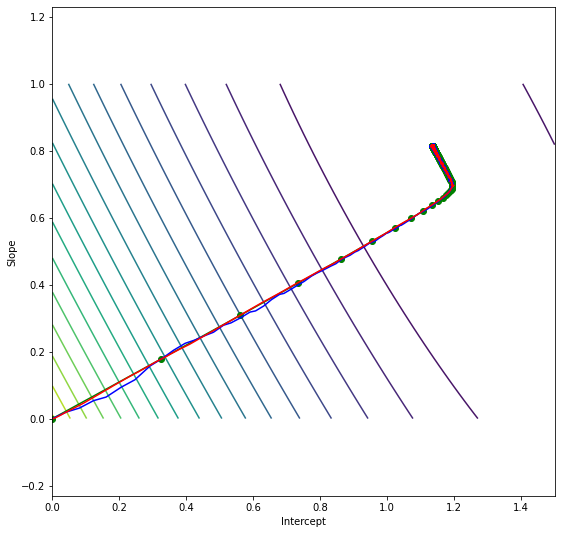

In [60]:

# Plot error surface
plt.contour(w0s,w1s,L_grid,20)

#Plot batch gradient descent, SGD, and SGD w/ momentum
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[:,0],w_momen[:,1],'r-')
plt.axis('equal')

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

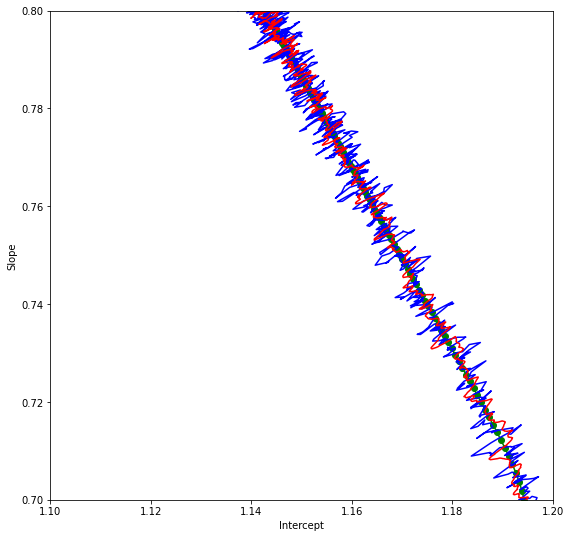

In [61]:
# Same as above but zoomed in

plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[:,0],w_momen[:,1],'r-')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.8)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

Momentum reduces the size of the wiggles due to the stochasticity in stochastic gradient descent.  

### RMSprop
A popular variant of gradient descent is called RMSprop, and it is similar to gradient descent with momentum, but with a twist: instead of keeping a running average of the gradient, RMSprop keeps a running average of the squared gradient.  Then, when it comes time to update the weights, it normalizes the gradient by the square-root of this average-squared gradient. 
$$
\bar{g^2}_i = m \bar{g^2}_{i-1} + (1-m) (\nabla \mathbf{w}_i)^2
$$
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta \frac{\nabla \mathbf{w}_i}{\sqrt{\bar{g^2}}}
$$



What does this do?  It effectively eliminates the scale of the gradient from the problem, and we only go downhill based on the sign, which is very useful when the gradients of the different parameters are very different from one another.  The momentum is necessary because the sign of the gradient can jump around alot with SGD, so it's better to know *generally* which direction is down.

In [62]:
# Initialize weights
w = np.array([0.,0.])

# Initialize storage
w_momen = [w.copy()]
w_mepoch = [w.copy()]

# Set learning rate (Lower because this method learns really fast!)
eta = 0.0001

# Set momentum
momentum = 0.9

# Initialize average squared gradient
g2 = 0

# Iterate over 10000 epochs
for i in range(10000):

    # Randomly shuffle indices
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    
    # Loop over shuffled indices
    for j in random_indices:
        
        # Extract single data point
        x_sample = x[j]
        y_sample = y[j]
        
        # Compute the gradient
        gradient = G(w,np.array([x_sample]),np.array([y_sample]))
        
        # TODO: Update averaged square gradient
        g2 = momentum * g2 + (1 - momentum) * (gradient ** 2)
        
        #TODO: Update with gradient normalized by root square average gradient
        w -= (eta * (gradient / np.sqrt(g2)))
        
        # Store weight values
        w_momen.append(w.copy())
    w_mepoch.append(w.copy())       
w_momen = np.array(w_momen)

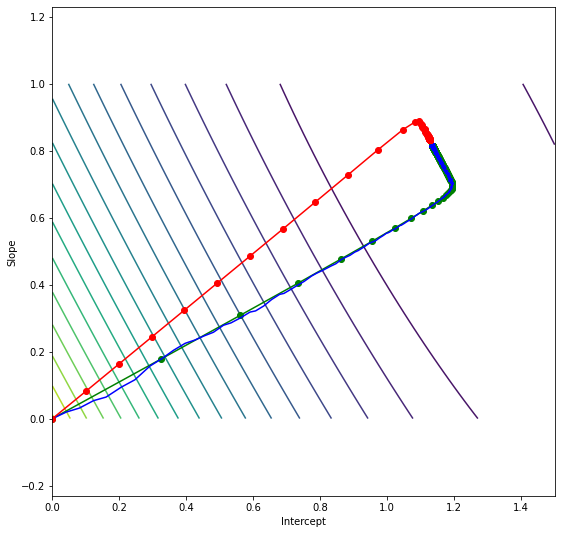

In [63]:
plt.contour(w0s,w1s,L_grid,20)
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[::1000,0],w_momen[::1000,1],'ro-')
plt.axis('equal')

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

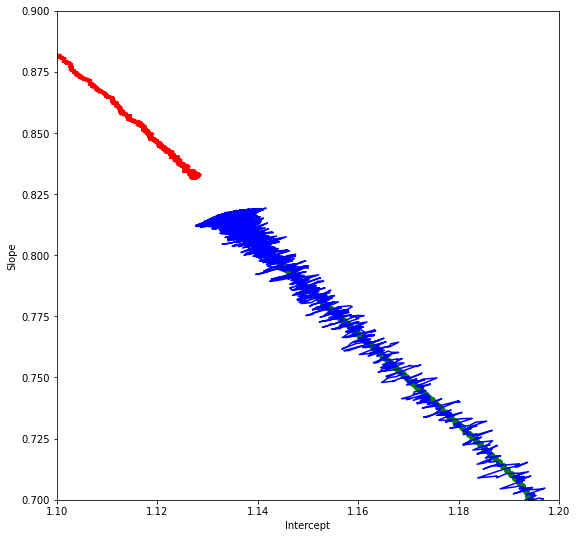

In [64]:
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[:,0],w_momen[:,1],'r-')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.9)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

In practice, RMSprop can be combined with normal momentum.  

These are just a few examples of the large scale gradient descent schemes that can be used for general optimization problems, but especially neural networks.  There are many, many other methods (a good overview can be found [here](http://ruder.io/optimizing-gradient-descent/) ).  However, effectively, these are all just slight variations on the general theme of figuring out which way is down, and going that direction.

Momentum reduces the size of the wiggles due to the stochasticity in stochastic gradient descent.  


### AdaGrad

Another optimizer that is similar to RMSProp is AdaGrad. This method adapts the learning rate to the parameters. Effectively, it performs smaller updates for parameters associated with frequently occurring features, and larger updates for parameters associated with infrequently occurring features.

This optimizer keeps track of the second moment of the gradient (think square) by summing it over all iterations. The result is that AdaGrad does well with cases where there are sparse gradients, for example in sparse datasets or near the end of optimization. 

It performs the update as follows:
$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta \frac{\nabla \mathbf{w}_i}{\sqrt{\bar{G_{ii}+ \epsilon}}}
$$
where $\mathbf{G_{ii}}$ is the sum of the current and all past diagonals of the matrix resulting from the multiplication of the gradient vector by itself. This can be optimized by simply performing the dot product. 

In [66]:
# Initialize weights
w = np.array([0.,0.])

# Initialize storage
w_momen = [w.copy()]
w_mepoch = [w.copy()]

# Set learning rate (Lower because this method learns really fast!)
eta = 0.01

# Set momentum
momentum = 0.9

# Initialize sum of squared gradients
g2 = 0

# Iterate over 10000 epochs
for i in range(10000):

    # Randomly shuffle indices
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    
    # Loop over shuffled indices
    for j in random_indices:
        
        # Extract single data point
        x_sample = x[j]
        y_sample = y[j]
        
        # Compute the gradient
        gradient = G(w,np.array([x_sample]),np.array([y_sample]))
        
        #TODO: Update sum of all squared gradients
        g2 += np.dot(gradient, gradient)
        
        #TODO: Update with gradient normalized by root square summed gradient
        w -= eta * (gradient / (np.sqrt(g2) + eta))
        
        # Store weight values
        w_momen.append(w.copy())
    w_mepoch.append(w.copy())       
w_momen = np.array(w_momen)

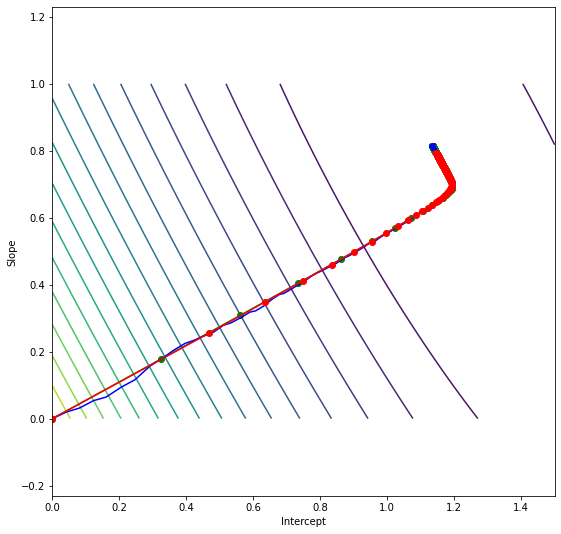

In [67]:
plt.contour(w0s,w1s,L_grid,20)
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[::1000,0],w_momen[::1000,1],'ro-')
plt.axis('equal')

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

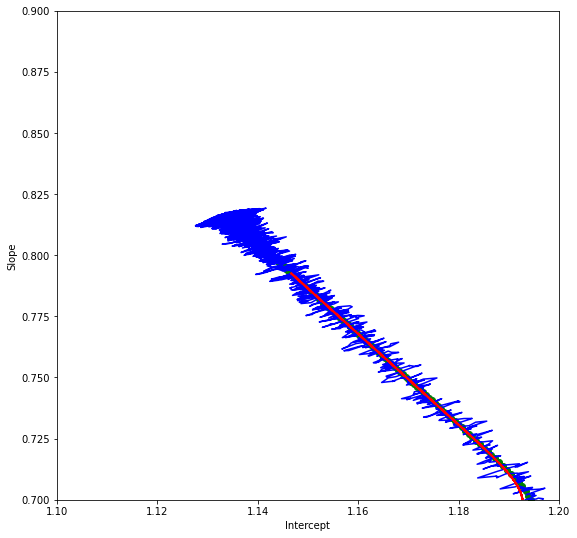

In [68]:
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[:,0],w_momen[:,1],'r-')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.9)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()


### Adam

Adam is an optimizer that performs well in a variety of settings due to the various improvements it makes over vanilla gradient descent. 

* Firstly, it implements momentum by keeping track of the gradients calculated at each step. By doing this and using it in the update step, it also does well in settings where gradients are sparse. 
* Secondly, it corrects for optimization bias that occurrs when using momentum. Few other methods do this. By doing so it improves the rate of optimization in early stages and can move toward convergence sooner than other methods. 
* Thirdly, and perhaps the most important differentiator of this method, it anneals the size of the update using a ratio of a running average of the first moment of the gradient with the square root of a running average of the second moment of the gradient. This means that the update step is invariant to the scale of the gradient and performs its update with respect to 1) the direction of the slope in the loss landscape and 2) the size of alpha.

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$
$$
\hat{m_t} = m_t / (1-\beta_1^t)
$$
$$
\hat{v_t} = v_t / (1-\beta_2^t)
$$

$$
\mathbf{w}_{i+1} = \mathbf{w}_i - \eta \frac{\hat{m_t}}{\sqrt{\hat{v_t}}+ \epsilon}
$$

In [69]:
# Initialize weights
w = np.array([0.,0.])

# Initialize storage
w_momen = [w.copy()]
w_mepoch = [w.copy()]

# Set learning rate (Lower because this method learns really fast!)
eta = 0.0001

# Set parameters beta_1 and beta_2
beta_1 = 0.9
beta_2 = 0.999

# Initialize exponentially decaying average of first moment
m = 0
# Initialize exponentially decaying average of second moment
v = 0

# Iterate over 10000 epochs
for i in range(1,10001):

    # Randomly shuffle indices
    random_indices = np.random.choice(range(len(x)),len(x),replace=False)
    
    # Loop over shuffled indices
    for j in random_indices:
        
        # Extract single data point
        x_sample = x[j]
        y_sample = y[j]
        
        # Compute the gradient
        gradient = G(w,np.array([x_sample]),np.array([y_sample]))
        
        #TODO: Update moments
        m = beta_1 * m + ((1 - beta_1) * gradient)
        v = beta_2 * v + ((1 - beta_2) * (gradient**2))
        
        #TODO: Correct moment bias
        m_hat = m / (1 - beta_1**i)
        v_hat = v / (1 - beta_2**i)

        #TODO: Update with gradient normalized by root square summed gradient
        w -= eta * (m_hat / (np.sqrt(v_hat) + eta))
        
        # Store weight values
        w_momen.append(w.copy())
    w_mepoch.append(w.copy())       
w_momen = np.array(w_momen)

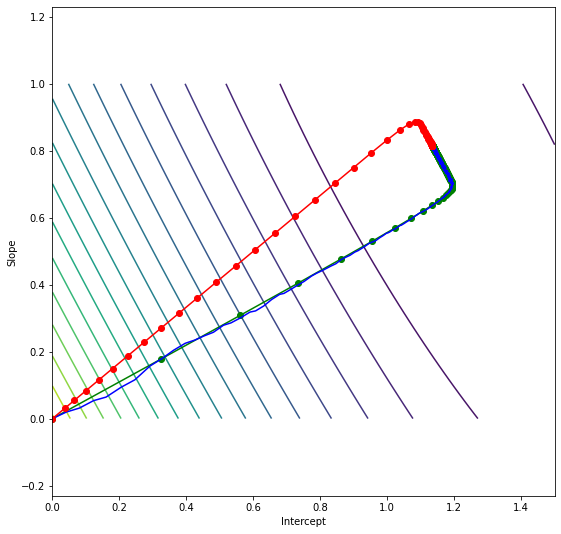

In [70]:
plt.contour(w0s,w1s,L_grid,20)
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[::1000,0],w_momen[::1000,1],'ro-')
plt.axis('equal')
#plt.xlim(1.1,1.2)
#plt.ylim(0.7,0.8)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

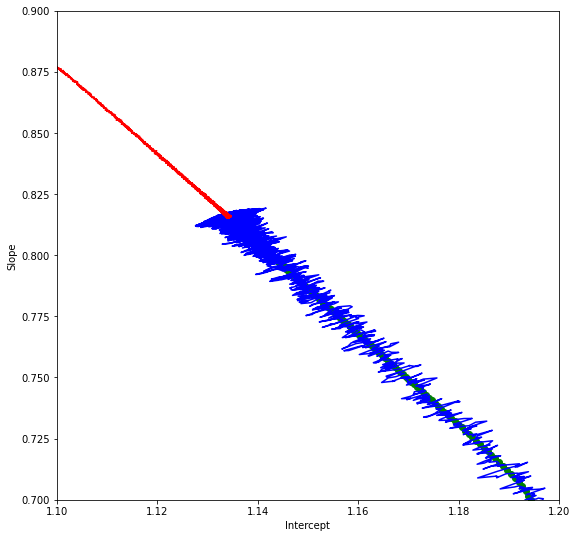

In [71]:
plt.plot(w_batch[:,0],w_batch[:,1],'go-')
plt.plot(w_stoch[:,0],w_stoch[:,1],'b-')
plt.plot(w_momen[:,0],w_momen[:,1],'r-')

plt.xlim(1.1,1.2)
plt.ylim(0.7,0.9)

plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

## Final Exercise: Adjusting hyperparameters

The hyperparameters associated with these algorithms can make a singificant difference to how they find optimal parameters. Try experimenting with the optimizers you implemented above and think about the following:
* Run the optimizers again using eta values that range from 1e-2 to 1e-4. What are suitable ranges of learning rate for the different optimizers? Why do they differ?
* Try different values for the momentum parameter (remember that in the case of Adam there are two). What impact does this have on the plots generated and why?
* Note the different step sizes in the plots generated for the different optimizers; think about what you observe and why.

## Optional Extra Learning Exercise:
Pytorch has all of these methods built in (and many more). You can explore some of them with the MNIST dataset, using the following code as a starting point. Specifically, try the following two experiments.

First, train for 50 (or more) epochs using three different optimization methods (options include SGD, Adagrad, RMSprop, and Adam, but you are free to use whatever you like; Documentation and options are [here](https://pytorch.org/docs/stable/optim.html)).  Record the loss and/or accuracy at each epoch for each method, and plot them all together. Identify which optimization method works best for this problem and discuss why you think this is the case.

Second, using the best method that you identified above, experiment with different hyperparameters as they are mentioned in the documentation. Note performance differences (in the sense of computational speed) between the different hyperparameter settings and discuss why this might be the case.

Model specification:

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """
        This method is where you'll want to instantiate parameters.
        we do this by creating two linear transformation functions, l1 and l2, which 
        have encoded in it both the weight matrices W_1 and W_2, and the bias vectors
        """
        super(Net,self).__init__()
        self.l1 = nn.Linear(784,128) # Transform from input to hidden layer
        self.l2 = nn.Linear(128,10)
        
   
    def forward(self,x):
        """
        This method runs the feedforward neural network.  It takes a tensor of size m x 784,
        applies a linear transformation, applies a sigmoidal activation, applies the second linear transform 
        and outputs the logits.
        """
        # Apply dropout to the input
        a1 = self.l1(x)
        z1 = torch.sigmoid(a1)
        
        # Apply dropout to the hidden layer
        a2 = self.l2(z1)

        return a2

Loading the data:

In [82]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True, as_frame=False)
X/=255.
y = y.astype(int)
X,X_test,y,y_test = train_test_split(X,y,test_size=10000)

# Extract number of data points, and the height and width of the images for later reshaping
m = X.shape[0]
n = X.shape[1]

h = 28
w = 28

N = 10

X = torch.from_numpy(X)
X_test = torch.from_numpy(X_test)
y = torch.from_numpy(y)
y_test = torch.from_numpy(y_test)

X = X.to(torch.float32)
X_test = X_test.to(torch.float32)
y = y.to(torch.long)
y_test = y_test.to(torch.long)

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

X = X.to(device)
X_test = X_test.to(device)
y = y.to(device)
y_test = y_test.to(device)

training_data = TensorDataset(X,y)
test_data = TensorDataset(X_test,y_test)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 256
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)


Example Training Loop for SGD (boilerplate code for implementing different optimizers):

In [83]:
SGD_loss = []
SGD_accuracy = []

epochs = 50

model = Net()
model.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

### Stochastic Gradient Descent ###
optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)

total_train = 0
correct_train = 0
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader:

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model(d)
        
        # Compute the loss
        loss = criterion(outputs,t)      

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())
        
    model.eval()
    # After each epoch, compute the test set accuracy
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
        
    # Print the epoch, the training loss, and the test set accuracy.
    print(epoch,loss.item(),100.*correct_train/total_train,100.*correct/total)
    SGD_loss.append(loss.item())
    SGD_accuracy.append(100.*correct/total)

0 2.297428846359253 11.256666666666666 11.23
1 2.288996696472168 11.258333333333333 11.23
2 2.2726824283599854 11.283333333333333 11.45
3 2.271657705307007 11.518333333333333 13.17
4 2.2685365676879883 12.219 16.7
5 2.2636334896087646 13.429444444444444 20.41
6 2.2560904026031494 14.75095238095238 24.51
7 2.241877317428589 16.301458333333333 27.77
8 2.2387452125549316 17.72074074074074 31.59
9 2.230226755142212 19.299833333333332 34.09
10 2.2220089435577393 20.793636363636363 36.49
11 2.214488983154297 22.16236111111111 39.5
12 2.2315385341644287 23.60205128205128 41.23
13 2.2008109092712402 24.908809523809524 43.66
14 2.2017314434051514 26.20277777777778 45.64
15 2.1982076168060303 27.405416666666667 47.8
16 2.198946237564087 28.650392156862747 48.78
17 2.1721749305725098 29.82064814814815 49.92
18 2.1777074337005615 30.91526315789474 51.24
19 2.1865313053131104 31.97608333333333 52.11
20 2.166302442550659 32.97571428571428 53.3
21 2.16278076171875 33.93181818181818 54.21
22 2.1328089